In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import sys
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from config import *
from N_ranking_utils import *
from N_plotting_utils import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_scores(algorithm_portfolio, do_discrete_ranking,model,train_benchmark,dimension,sample_count_dimension_factor,result_dir='results',include_sample_size_in_model_name=False):
    t=pd.read_csv(f'{data_dir}/{result_dir}/{sample_count_dimension_factor}d_samples/{dimension}d_generalization_discrete_ranking_{do_discrete_ranking}/{algorithm_portfolio}/all_scores_{model}_{train_benchmark}.csv',index_col=0)
    t=t.melt(id_vars=['fold','budget', 'train_name', 'test_name','model','algorithms','features','feature_group'])
    
    if include_sample_size_in_model_name:
        t['model']=t.apply(lambda x: f'{x["features"]} {sample_count_dimension_factor}d' if x['features']!='dummy' else x['features'], axis=1)
    else: 
        t['model']=t['features']
    return t

In [12]:
def plot_generalization_rankings_multiple_sample_sizes_per_budget(algorithm_portfolio, dimension, do_discrete_ranking, model='no_chain', plot_ranks=True, benchmarks=None, sample_count_dimension_factors=50,result_dir='results'):
    metrics=['misranking_score','loss']
    scores=[]
    all_results=pd.DataFrame()
    all_model_ranks=pd.DataFrame()
    if benchmarks is None:
        benchmarks=all_benchmarks
    for train_name in benchmarks:
        results_generalization=pd.concat([get_scores(algorithm_portfolio, do_discrete_ranking, model, train_name,dimension,sample_count_dimension_factor,result_dir,True) for sample_count_dimension_factor in sample_count_dimension_factors])
        #results_same=pd.concat([get_scores(algorithm_portfolio, do_discrete_ranking, model, train_name,dimension,sample_count_dimension_factor,'results_same_benchmark',True) for sample_count_dimension_factor in sample_count_dimension_factors])

        for budget in [10,30,50]:
            for score in metrics:

                for test_name in benchmarks:
                    if train_name==test_name:
                        continue
                    t=results_generalization
                    tt=t.query('budget==@budget and train_name==@train_name and test_name==@test_name and variable==@score')
                    tt['feature_group']=tt.apply(lambda x: x['feature_group'] if x['features']!='dummy' else 'dummy', axis=1)
                    #tt['model']=tt['model'].apply(lambda x: f'{x} {sample_count_dimension_factor}d' if x!='dummy' else x)
                    tt_medians=tt.groupby(['model','feature_group']).median(numeric_only=True).sort_values('value', ascending=False)
                    if plot_ranks:
                        model_ranks=list(zip(tt_medians.index, tt_medians.reset_index().index))
                    else:
                        model_ranks=list(zip(tt_medians.index, tt_medians['value']))
                    model_ranks={m[0]:m[1] for m in model_ranks}

                    model_ranks_df=pd.DataFrame(model_ranks, index=pd.MultiIndex.from_tuples([(budget,score,train_name, test_name)], names=['budget','score','train_name','test_name']))
                    #print(model_ranks_df)
                    all_model_ranks=pd.concat([all_model_ranks,model_ranks_df])

    

    # We use a for loop to fill in each subplot with a heatmap
    for budget_index, budget in enumerate([10,30,50]):
        for score_index, score in enumerate(['loss']):
            temp=all_model_ranks.query('budget==@budget and score==@score').reset_index()
            temp['train_name']=temp['train_name'].apply(benchmark_name_mapping)
            temp['test_name']=temp['test_name'].apply(benchmark_name_mapping)
            temp=temp.drop(columns=['budget','score']).set_index(['train_name','test_name'])

            temp.index=['-'.join(t) for t in temp.index]
            temp.index.name='train-test'

            temp=temp.reset_index().melt(id_vars=[('train-test','')], value_vars=list(temp.columns)).rename(columns={('train-test',''):'train-test', 'variable_0':'features','variable_1':'feature_group'})

            temp['budget']=budget
            temp['score']=score
            all_results=pd.concat([all_results,temp])
            
    #all_results=all_results.query('features!="ela+ela_sy 50d" or feature_group=="all"')
    
    plt.figure()
    all_results['feature_group']=all_results['feature_group'].apply(lambda x: x if not x.startswith('sy_') else x.replace('sy_',''))
    all_results=all_results.sort_values('features')
    feature_name_mappings={'ela 50d':'ELA','ela_sy 50d':'ELA Y Scaling', 'ela+ela_sy 50d':'Merged','dummy':'Dummy'}

    all_results['features']=all_results['features'].apply(lambda x:feature_name_mappings[x])

    
    for budget in ['all',10,30,50]:
        
        t=all_results.query('budget==@budget') if budget!='all' else all_results.copy().groupby(['feature_group','features','train-test']).mean(numeric_only=True).reset_index()
        t=t.pivot(columns=['train-test'],index=['feature_group','features'],values='value')
        fig,axes=plt.subplots(len(all_results['feature_group'].unique())-1,1, figsize=(7,13),sharex=True)
        for feature_group_index,feature_group in enumerate(sorted(set(all_results['feature_group'].unique()).difference({'dummy'}))):
            t_minus_ela=t.loc[(feature_group,)].append(t.loc[('dummy',)])
            cmap_to_use='YlGnBu'

            ax=sns.heatmap(t_minus_ela.fillna(t_minus_ela.loc['Dummy',:]),annot=True,ax=axes[feature_group_index], cmap=cmap_to_use, fmt='.2f')
            ax.set_title(f'Feature group: {feature_group}')
        plt.tight_layout()
        plt.savefig(f'{data_dir}/figures_results_ela_scaling/heatmaps_budget_{budget}_{result_dir}_sample_sizes_{dimension}d_{algorithm_portfolio}_{model}_plot_ranks_{plot_ranks}.pdf')

        plt.show()
    return all_results

<Figure size 640x480 with 0 Axes>

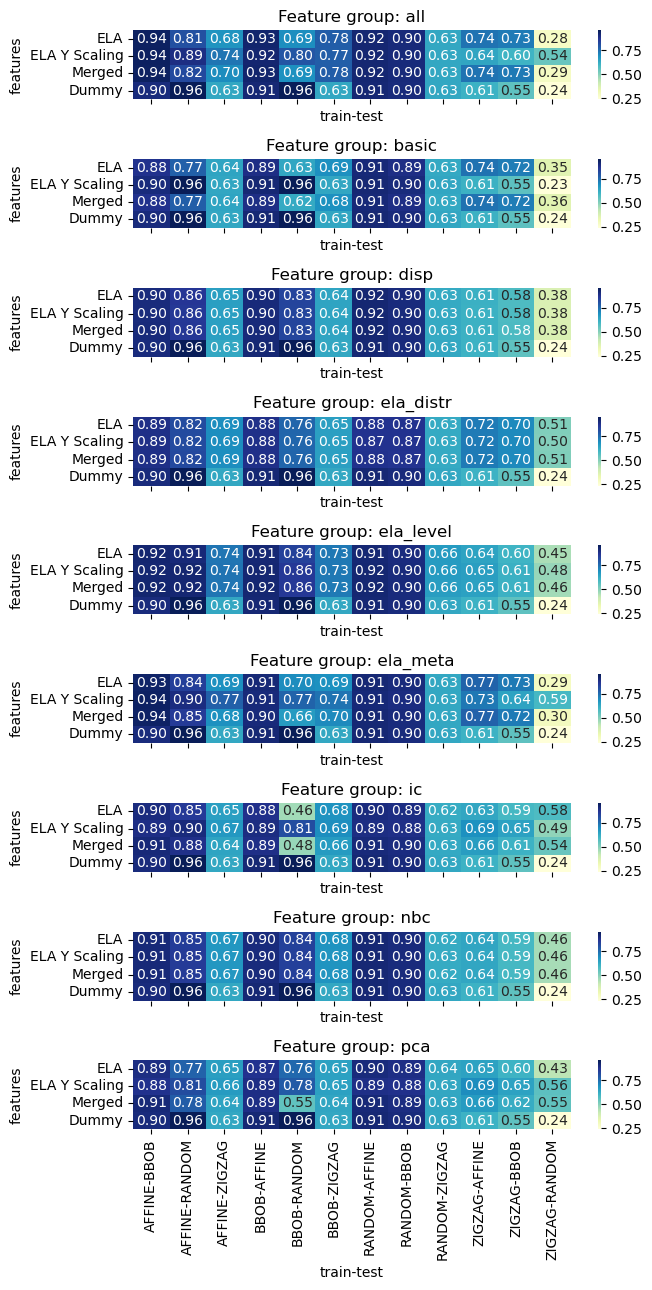

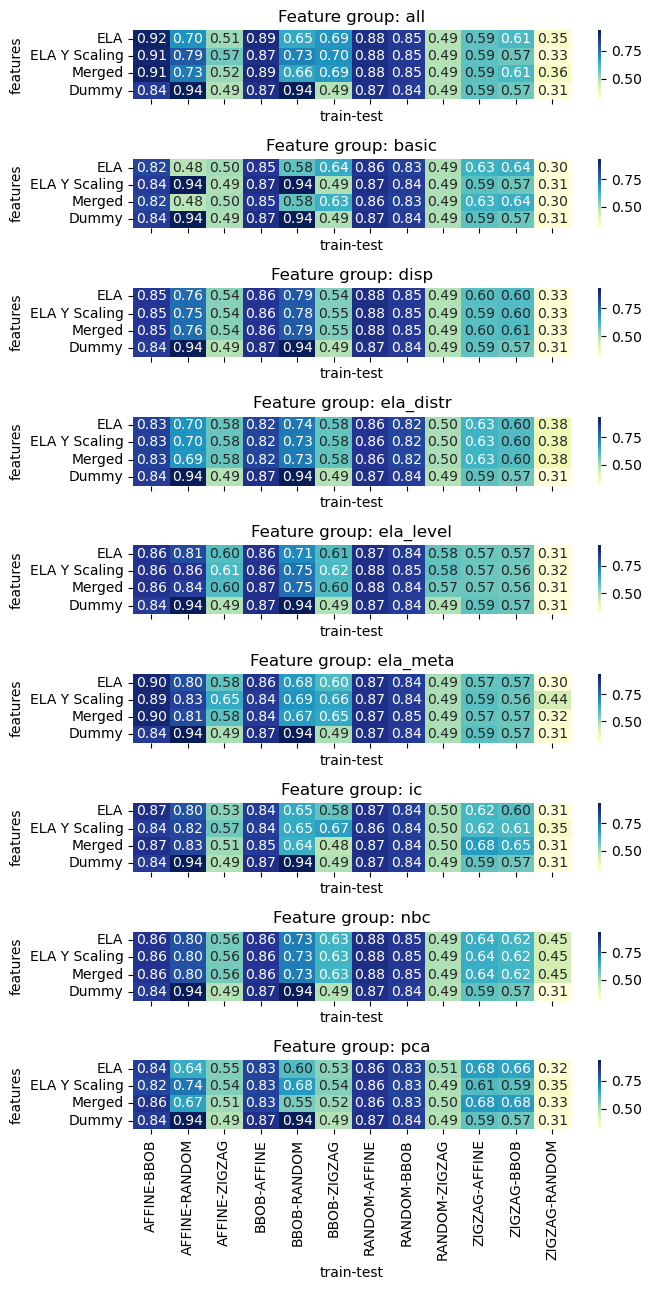

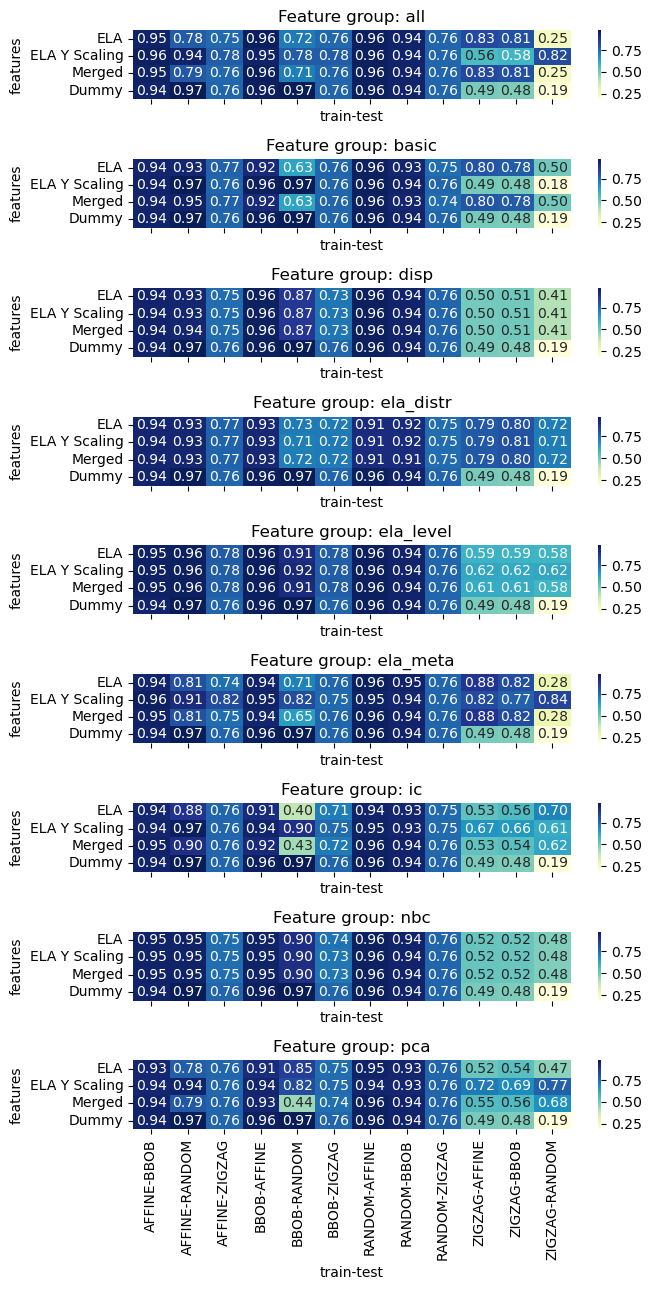

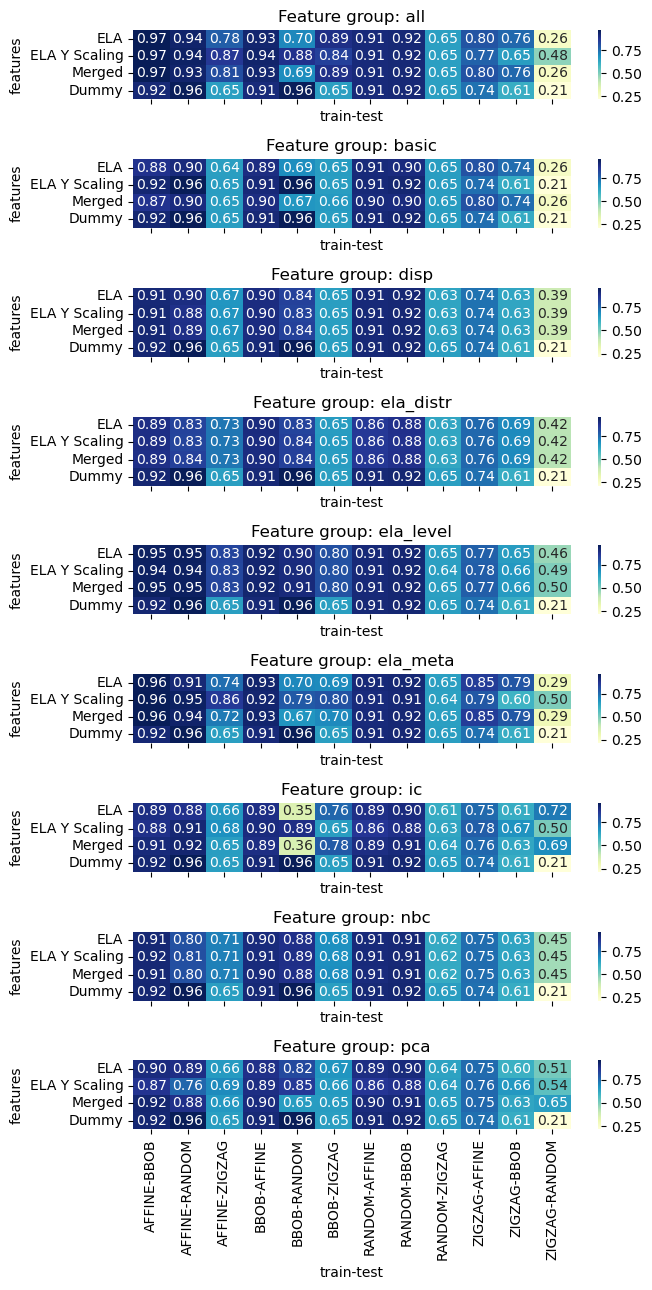

In [14]:
all_results=plot_generalization_rankings_multiple_sample_sizes_per_budget("DE-GA-ES-PSO",10,False, model='rf', plot_ranks=False,sample_count_dimension_factors=[50],result_dir='results_ELA_SCALING_ANALYSIS_FEATURE_GROUPS', benchmarks=['m4','affine','bbob','random'])

<Figure size 640x480 with 0 Axes>

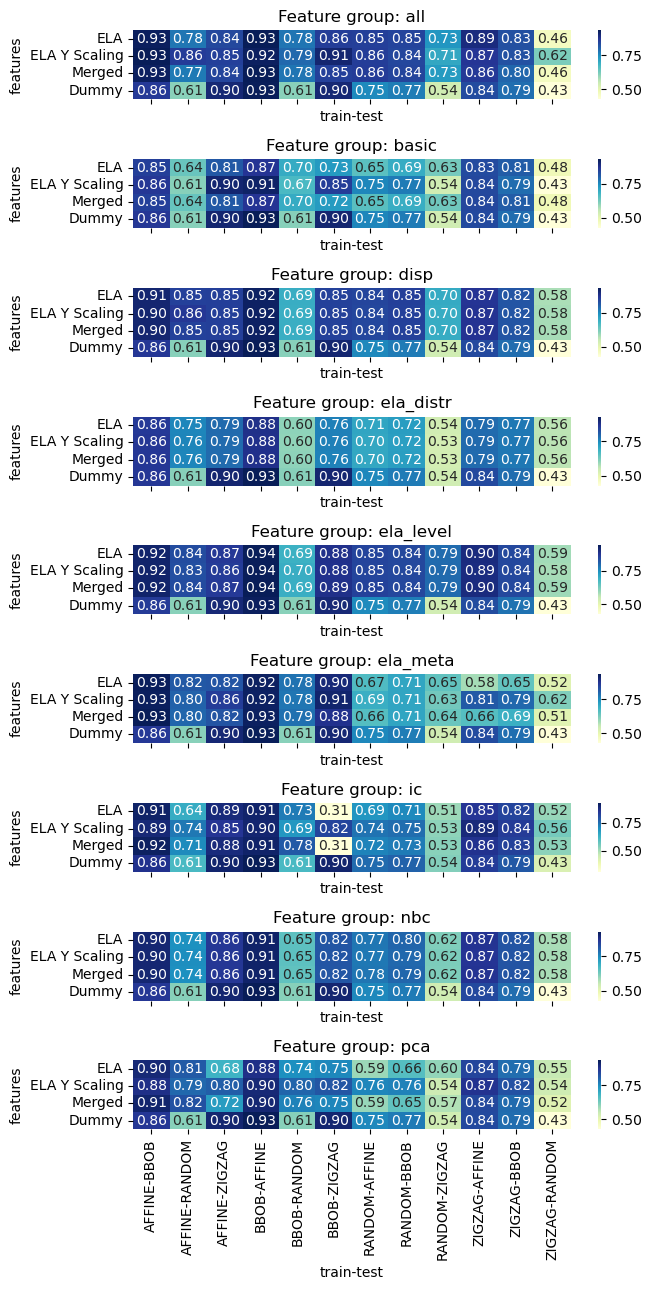

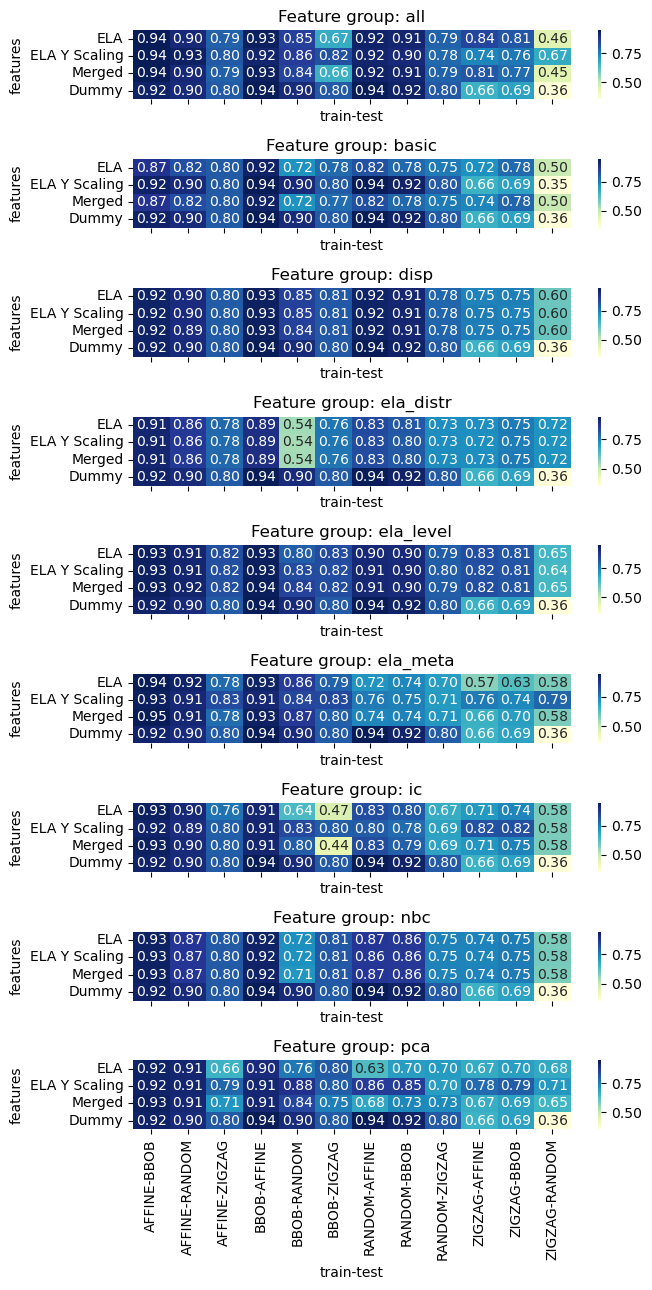

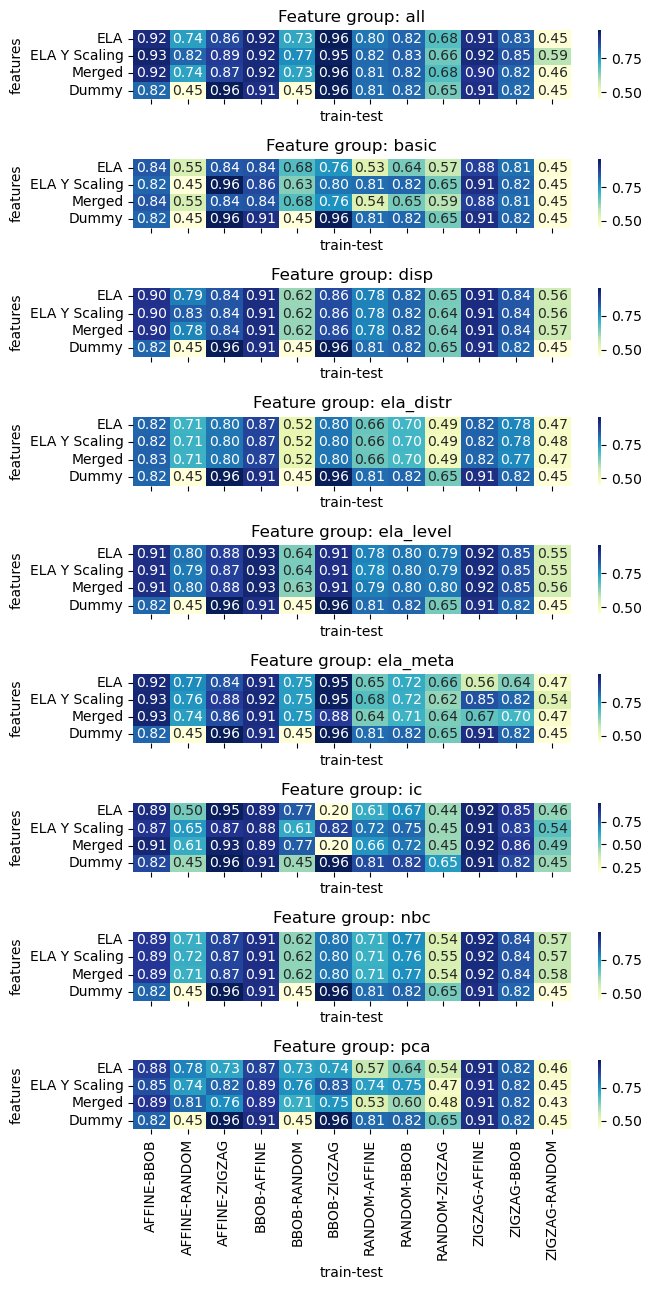

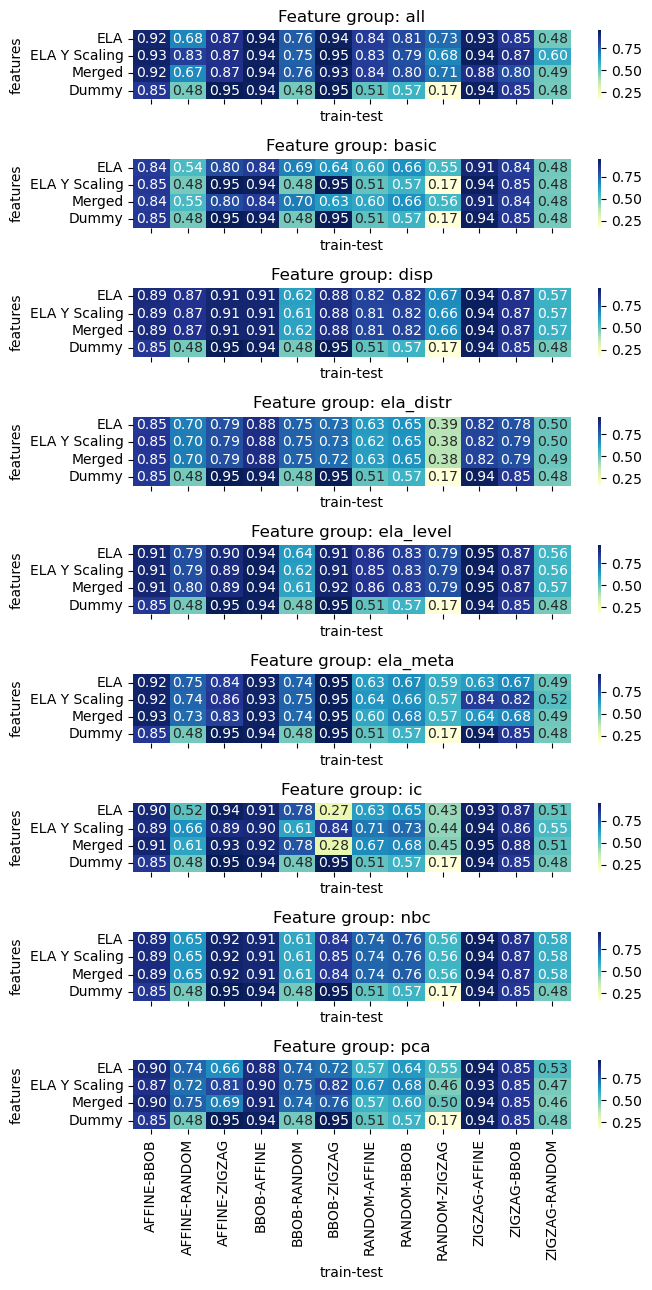

In [13]:
all_results=plot_generalization_rankings_multiple_sample_sizes_per_budget("DE-GA-ES-PSO",3,False, model='rf', plot_ranks=False,sample_count_dimension_factors=[50],result_dir='results_ELA_SCALING_ANALYSIS_FEATURE_GROUPS', benchmarks=['m4','affine','bbob','random'])